In [1]:
%matplotlib inline


数据加载和处理
====================================
作者：`Tina`
时间：2018-05-06

在解决任何机器学习问题上的很多努力都是在对数据进行准备。PyTorch提供了许多工具，使数据加载变得容易，也使代码更具可读性。在本教程中，我们将了解如何加载和预处理/扩充数据。

要运行本教程，请确保安装了以下软件包：

-  ``scikit-image``：对于图像输入和变换
-  ``pandas``：为了方便csv解析




In [4]:
from __future__ import print_function, division
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

plt.ion()   # interactive mode

我们要处理的数据集是面部表情。脸部要进行关键点的标注，总的来说，每一张脸都有68个不同landmark。

从这里下载[数据集](https://download.pytorch.org/tutorial/faces.zip)。这些图像都在一个名为'faces/'的文件夹里。

这个数据集实际上是通过应用“dlib”[姿势估计生成的](http://blog.dlib.net/2014/08/real-time-face-pose-estimation.html)，人脸来自于ImageNet。

数据集附带一个带有注释的csv文件，如下所显示：

    image_name,part_0_x,part_0_y,part_1_x,part_1_y,part_2_x, ... ,part_67_x,part_67_y
    0805personali01.jpg,27,83,27,98, ... 84,134
    1084239450_e76e00b7e7.jpg,70,236,71,257, ... ,128,312

让我们快速阅读CSV，并在(N, 2)的数组中获取标注信息。N是landmark的数量。




In [5]:
landmarks_frame = pd.read_csv('faces/face_landmarks.csv')

n = 65
img_name = landmarks_frame.iloc[n, 0]
landmarks = landmarks_frame.iloc[n, 1:].as_matrix()
landmarks = landmarks.astype('float').reshape(-1, 2)

print('Image name: {}'.format(img_name))
print('Landmarks shape: {}'.format(landmarks.shape))
print('First 4 Landmarks: {}'.format(landmarks[:4]))

Image name: person-7.jpg
Landmarks shape: (68, 2)
First 4 Landmarks: [[32. 65.]
 [33. 76.]
 [34. 86.]
 [34. 97.]]


让我们编写一个简单的帮助函数来显示一个图像和它的landmark，并用它来显示一个示例。



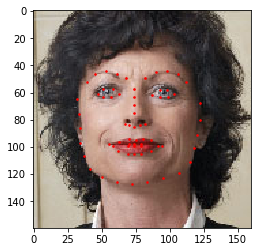

In [6]:
def show_landmarks(image, landmarks):
    """Show image with landmarks"""
    plt.imshow(image)
    plt.scatter(landmarks[:, 0], landmarks[:, 1], s=10, marker='.', c='r')
    plt.pause(0.001)  #暂停一下，这样plot就会更新

plt.figure()
show_landmarks(io.imread(os.path.join('faces/', img_name)),
               landmarks)
plt.show()

数据集类
-------------

``torch.utils.data.Dataset``是一个数据集抽象类。
自定义数据集应该继承``Dataset``并覆盖下面的方法：

-  ``__len__``以便于``len(dataset)``返回数据集的大小。
-  ``__getitem__``为了支持索引以使``dataset[i]``可以用来获得第$i$个样本

让我们为人脸landmark数据集创建一个dataset类。我们会在``__init__``中读csv，但是把图像的读取留给``__getitem__``。这是内存效率，因为所有的图像都不会同时存储在内存中，而是按需要读取。

我们的数据集的样本将是一个字典
``{'image': image, 'landmarks': landmarks}``。我们的数据集将会有一个可选的参数``transform``因此，任何需要的处理都可以应用到样本上。我们将在下一节中看到``transform``的有用性。




In [1]:
class FaceLandmarksDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, csv_file, root_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.landmarks_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.landmarks_frame)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir,
                                self.landmarks_frame.iloc[idx, 0])
        image = io.imread(img_name)
        landmarks = self.landmarks_frame.iloc[idx, 1:].as_matrix()
        landmarks = landmarks.astype('float').reshape(-1, 2)
        sample = {'image': image, 'landmarks': landmarks}

        if self.transform:
            sample = self.transform(sample)

        return sample

NameError: name 'Dataset' is not defined

现在实例化这个类并遍历数据样本。我们将打印前四个样本的大小并显示它们的landmark。




0 (324, 215, 3) (68, 2)


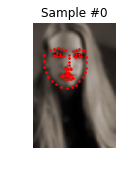

1 (500, 333, 3) (68, 2)


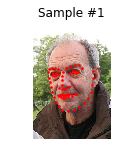

2 (250, 258, 3) (68, 2)


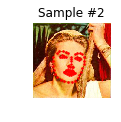

3 (434, 290, 3) (68, 2)


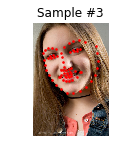

In [8]:
face_dataset = FaceLandmarksDataset(csv_file='faces/face_landmarks.csv',
                                    root_dir='faces/')

fig = plt.figure()

for i in range(len(face_dataset)):
    sample = face_dataset[i]

    print(i, sample['image'].shape, sample['landmarks'].shape)

    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    show_landmarks(**sample)

    if i == 3:
        plt.show()
        break

Transforms
----------

我们可以从上面看到的一个问题，这些样本的大小并不相同。大多数神经网络都期望有固定大小的图像。因此，我们需要编写一些预处理代码。
让我们创建三个转换：

-  ``Rescale``: 缩放图像
-  ``RandomCrop``:随机裁切，进行数据扩增
-  ``ToTensor``: 将numpy图像转换为torch图像(我们需要交换坐标轴)。

我们将把它们写成可调用的类，而不是简单的函数，因此转换的参数不需要每次调用时都被传递。为此，我们只需要实现 ``__call__`` 方法，并且如果需要,还要实现 ``__init__``方法。然后我们可以这样使用转换：

    tsfm = Transform(params)
    transformed_sample = tsfm(sample)

下面观察这些变换是如何在图像和landmark上应用的。




In [9]:
class Rescale(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']

        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)

        img = transform.resize(image, (new_h, new_w))

        # h and w are swapped for landmarks because for images,
        # x and y axes are axis 1 and 0 respectively
        landmarks = landmarks * [new_w / w, new_h / h]

        return {'image': img, 'landmarks': landmarks}


class RandomCrop(object):
    """Crop randomly the image in a sample.

    Args:
        output_size (tuple or int): Desired output size. If int, square crop
            is made.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']

        h, w = image.shape[:2]
        new_h, new_w = self.output_size

        top = np.random.randint(0, h - new_h)
        left = np.random.randint(0, w - new_w)

        image = image[top: top + new_h,
                      left: left + new_w]

        landmarks = landmarks - [left, top]

        return {'image': image, 'landmarks': landmarks}


class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        image = image.transpose((2, 0, 1))
        return {'image': torch.from_numpy(image),
                'landmarks': torch.from_numpy(landmarks)}

## 组合变换

现在，我们对一个样本应用变换。

假设我们想要将图像的较短的边重新缩放到256，然后随机地从它中选取一个大小为224的方块。也就是，我们想组合``Rescale``和``RandomCrop`` 变换。
``torchvision.transforms.Compose``是一个简单的可调用的类，它允许我们这样做。




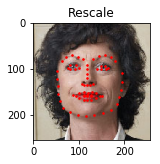

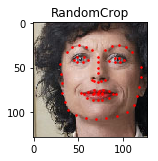

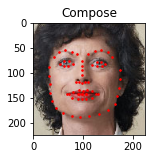

In [10]:
scale = Rescale(256)
crop = RandomCrop(128)
composed = transforms.Compose([Rescale(256),
                               RandomCrop(224)])

# Apply each of the above transforms on sample.
fig = plt.figure()
sample = face_dataset[65]
for i, tsfrm in enumerate([scale, crop, composed]):
    transformed_sample = tsfrm(sample)

    ax = plt.subplot(1, 3, i + 1)
    plt.tight_layout()
    ax.set_title(type(tsfrm).__name__)
    show_landmarks(**transformed_sample)

plt.show()

遍历数据集
-----------------------------

让我们把这些放在一起来创建一个组合了转换的数据集
总而言之，每次这个数据集被取样时：

-  从文件中读取一个图像
-  转换被应用到读取的图像上
-  因为其中一个转换是随机的，所以数据是在采样上增加的

我们可以用``for i in range``循环迭代已创建的数据集


In [11]:
transformed_dataset = FaceLandmarksDataset(csv_file='faces/face_landmarks.csv',
                                           root_dir='faces/',
                                           transform=transforms.Compose([
                                               Rescale(256),
                                               RandomCrop(224),
                                               ToTensor()
                                           ]))

for i in range(len(transformed_dataset)):
    sample = transformed_dataset[i]

    print(i, sample['image'].size(), sample['landmarks'].size())

    if i == 3:
        break

0 torch.Size([3, 224, 224]) torch.Size([68, 2])
1 torch.Size([3, 224, 224]) torch.Size([68, 2])
2 torch.Size([3, 224, 224]) torch.Size([68, 2])
3 torch.Size([3, 224, 224]) torch.Size([68, 2])


然而，我们通过使用简单的“for”循环遍历数据，从而丢失了许多特性。特别是，我们丢失了：

-  批处理数据
-  打乱数据
-  使用``multiprocessing``并行加载数据

``torch.utils.data.DataLoader``是一个提供所有这些特性的迭代器。下面使用的参数应该是清楚的。感兴趣的一个参数是``collate_fn``。你可以指定``collate_fn``参数来说明如何使用这些样本进行批处理。但是，对于大多数用例，默认的collate应该行得通。



0 torch.Size([4, 3, 224, 224]) torch.Size([4, 68, 2])
1 torch.Size([4, 3, 224, 224]) torch.Size([4, 68, 2])
2 torch.Size([4, 3, 224, 224]) torch.Size([4, 68, 2])
3 torch.Size([4, 3, 224, 224]) torch.Size([4, 68, 2])


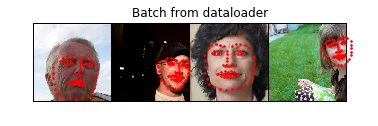

In [12]:
dataloader = DataLoader(transformed_dataset, batch_size=4,
                        shuffle=True, num_workers=4)


# Helper function to show a batch
def show_landmarks_batch(sample_batched):
    """Show image with landmarks for a batch of samples."""
    images_batch, landmarks_batch = \
            sample_batched['image'], sample_batched['landmarks']
    batch_size = len(images_batch)
    im_size = images_batch.size(2)

    grid = utils.make_grid(images_batch)
    plt.imshow(grid.numpy().transpose((1, 2, 0)))

    for i in range(batch_size):
        plt.scatter(landmarks_batch[i, :, 0].numpy() + i * im_size,
                    landmarks_batch[i, :, 1].numpy(),
                    s=10, marker='.', c='r')

        plt.title('Batch from dataloader')

for i_batch, sample_batched in enumerate(dataloader):
    print(i_batch, sample_batched['image'].size(),
          sample_batched['landmarks'].size())

    # observe 4th batch and stop.
    if i_batch == 3:
        plt.figure()
        show_landmarks_batch(sample_batched)
        plt.axis('off')
        plt.ioff()
        plt.show()
        break

后记: torchvision
----------------------

``torchvision``包提供一些公共数据集和转换操作。你甚至不需要写自定义类。在torchvision中可用的一个通用数据集是``ImageFolder``。
它假定图像的组织方式如下：

    root/ants/xxx.png
    root/ants/xxy.jpeg
    root/ants/xxz.png
    .
    .
    .
    root/bees/123.jpg
    root/bees/nsdf3.png
    root/bees/asd932_.png

“蚂蚁”,“蜜蜂”等是类标签，类似的在``PIL.Image``上的通用变换比如``RandomHorizontalFlip``， ``Scale``也是可用的。你可以用这些来写一个dataloader，像这样：
```
  import torch
  from torchvision import transforms, datasets

  data_transform = transforms.Compose([
          transforms.RandomSizedCrop(224),
          transforms.RandomHorizontalFlip(),
          transforms.ToTensor(),
          transforms.Normalize(mean=[0.485, 0.456, 0.406],
                               std=[0.229, 0.224, 0.225])
      ])
  hymenoptera_dataset = datasets.ImageFolder(root='hymenoptera_data/train',
                                             transform=data_transform)
  dataset_loader = torch.utils.data.DataLoader(hymenoptera_dataset,
                                               batch_size=4, shuffle=True,
                                               num_workers=4)
```
一个训练代码的例子请参见[transfer_learning_tutorial](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html)

